# **📄 Document type classification EDA**

## Contents
- Prepare Environments
- Import Library & Define Dataset
- Load Data
- EDA


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [19]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install wandb
# !pip install matplotlib
# !pip install seaborn

## 2. Import Library

In [20]:
import os
from PIL import Image  # Pillow 라이브러리에서 Image 모듈 임포트
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from matplotlib import font_manager
# NanumGothic.otf 글꼴 경로
font_path = 'font/NanumGothic.otf'
font_prop = font_manager.FontProperties(fname=font_path)

pre_path = ''
images_folder_path = pre_path + 'data/train_kr'
meta_kr_csv_path = pre_path + 'data/meta_kr.csv'
train_kr_csv_path = pre_path + 'data/train_kr.csv'
meta_kr_df = pd.read_csv(pre_path + 'data/meta_kr.csv')
train_kr_df = pd.read_csv(pre_path + 'data/train_kr.csv')

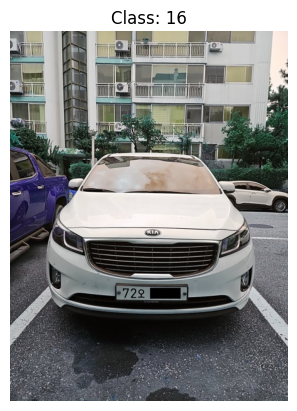

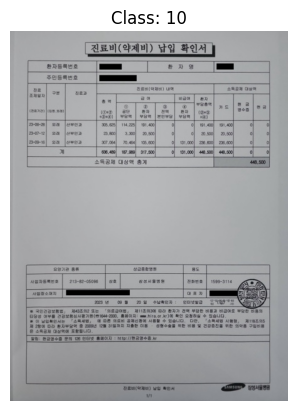

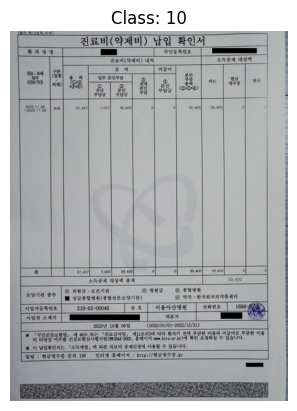

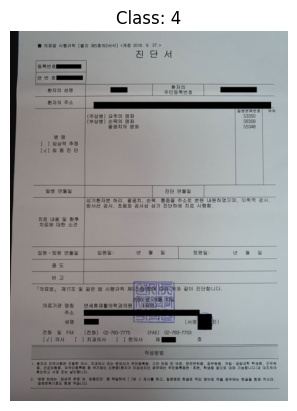

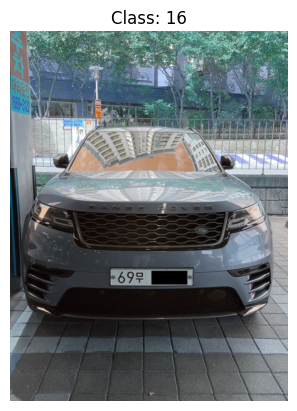

In [21]:
for index, row in train_kr_df.head().iterrows():
    image_path = images_folder_path + '/' + row['ID']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f"Class: {row['target']}")
    plt.axis('off')
    plt.show()

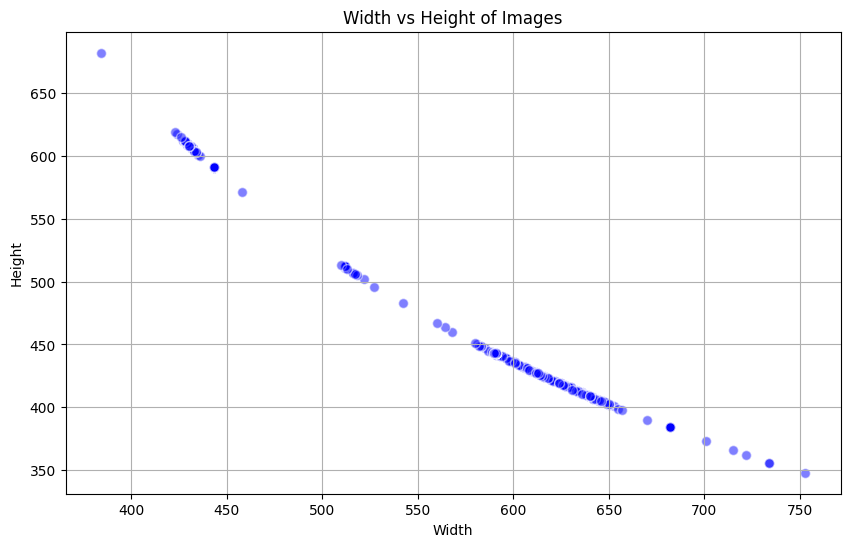

In [22]:
# 이미지의 너비와 높이를 저장할 리스트
widths = []
heights = []

# 데이터 폴더 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir(images_folder_path):
    if filename.lower().endswith('.jpg'):
        image_path = os.path.join(images_folder_path, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# 스캐터 차트 그리기
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, c='blue', edgecolors='w', s=50)
plt.title('Width vs Height of Images')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()


Average Width: 497.61
Average Height: 538.17
Median Width: 443.00
Median Height: 591.00


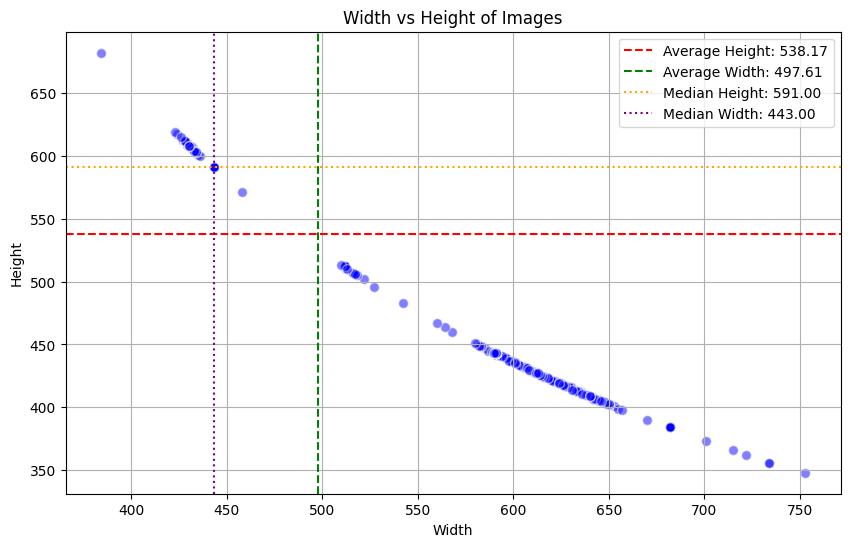

In [23]:
# 이미지의 너비와 높이를 저장할 리스트
widths = []
heights = []

# 데이터 폴더 내의 모든 이미지 파일에 대해 반복
for filename in os.listdir(images_folder_path):
    if filename.lower().endswith('.jpg'):
        image_path = os.path.join(images_folder_path, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

# 평균과 중앙값 계산
average_width = sum(widths) / len(widths) if widths else 0
average_height = sum(heights) / len(heights) if heights else 0
median_width = np.median(widths) if widths else 0
median_height = np.median(heights) if heights else 0

# 평균과 중앙값 출력
print(f"Average Width: {average_width:.2f}")
print(f"Average Height: {average_height:.2f}")
print(f"Median Width: {median_width:.2f}")
print(f"Median Height: {median_height:.2f}")

# 스캐터 차트 그리기
plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, c='blue', edgecolors='w', s=50)
plt.title('Width vs Height of Images')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)

# 평균 너비와 높이, 중앙값을 차트에 표시
plt.axhline(y=average_height, color='r', linestyle='--', label=f'Average Height: {average_height:.2f}')
plt.axvline(x=average_width, color='g', linestyle='--', label=f'Average Width: {average_width:.2f}')
plt.axhline(y=median_height, color='orange', linestyle=':', label=f'Median Height: {median_height:.2f}')
plt.axvline(x=median_width, color='purple', linestyle=':', label=f'Median Width: {median_width:.2f}')
plt.legend()

plt.show()

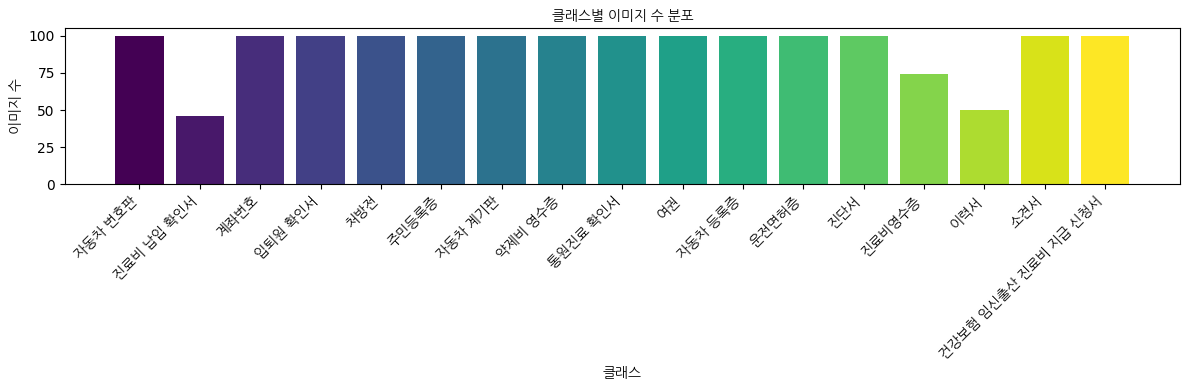

In [24]:
# meta_kr.csv 파일을 읽어 target과 class_name_ko 매핑
target_to_ko = {}
with open(meta_kr_csv_path, mode='r', encoding='utf-8') as meta_file:
    reader = pd.read_csv(meta_file)
    target_to_ko = dict(zip(reader['target'], reader['class_name_ko']))

# 각 클래스(target)의 이미지 수를 계산
class_counts = train_kr_df['target'].value_counts()

# 클래스별 한국어 이름으로 변환
class_names_ko = [target_to_ko[target] for target in class_counts.index]
class_counts_ko = class_counts.sort_index()

# viridis 색상맵을 생성
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(class_counts_ko)))

# 바 차트 생성
plt.figure(figsize=(12, 4))
plt.bar(class_names_ko, class_counts_ko, color=colors)
plt.xlabel('클래스', fontproperties=font_prop)
plt.ylabel('이미지 수', fontproperties=font_prop)
plt.title('클래스별 이미지 수 분포', fontproperties=font_prop)
plt.xticks(rotation=45, ha='right', fontproperties=font_prop)
plt.tight_layout()

# 플롯 저장 및 표시
plt.savefig('class_distribution_viridis.png', bbox_inches='tight')
plt.show()

## 클래스별 이미지 개수 파악 결론

- 클래스별 이미지 개수에 차이가 있어서, stratified k-fold 로 진행해야 할 것으로 예상된다.

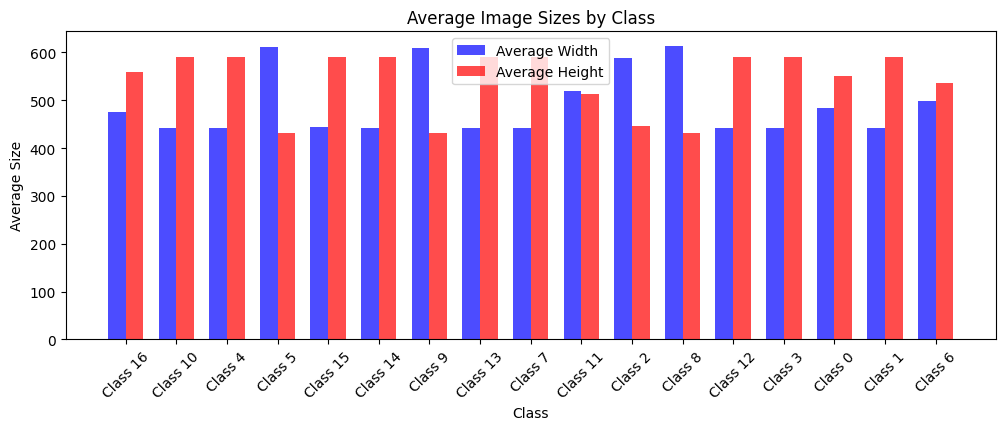

In [25]:
class_image_sizes = {}

for index, row in train_kr_df.iterrows():
    image_path = os.path.join(images_folder_path, row['ID'])
    image = Image.open(image_path)
    width, height = image.size
    target = row['target']
    if target not in class_image_sizes:
        class_image_sizes[target] = []
    class_image_sizes[target].append((width, height))

class_average_sizes = {}

for target, sizes in class_image_sizes.items():
    widths, heights = zip(*sizes)
    class_average_sizes[target] = (sum(widths) / len(widths), sum(heights) / len(heights))

plt.figure(figsize=(12, 4))

class_labels = [f"Class {target}" for target in class_average_sizes.keys()]
average_widths = [size[0] for size in class_average_sizes.values()]
average_heights = [size[1] for size in class_average_sizes.values()]

bar_width = 0.35
index = range(len(class_labels))

plt.bar(index, average_widths, bar_width, color='b', alpha=0.7, label='Average Width')
plt.bar([i + bar_width for i in index], average_heights, bar_width, color='r', alpha=0.7, label='Average Height')
plt.title('Average Image Sizes by Class')
plt.xlabel('Class')
plt.ylabel('Average Size')
plt.xticks([i + bar_width / 2 for i in index], class_labels, rotation=45)
plt.legend()
plt.show()

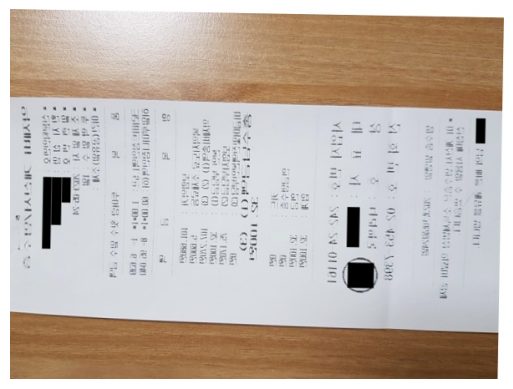

In [26]:
# 원본 이미지
image = cv2.imread("data/test/00c0dabb63ca7a16.jpg") # 이미지 로드
plt.imshow(image), plt.axis("off") # 이미지 출력
plt.show()


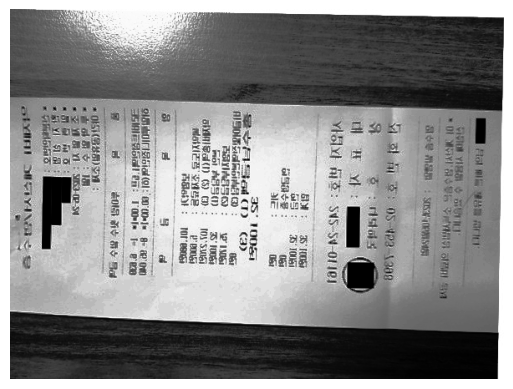

In [27]:
# 대비 높히기
image = cv2.imread("./data/test/00c0dabb63ca7a16.jpg", cv2.IMREAD_GRAYSCALE) # 흑백 이미지로 로드
image_enhanced = cv2.equalizeHist(image) # 이미지 대비 향상
plt.imshow(image_enhanced, cmap="gray"), plt.axis("off")
plt.show()

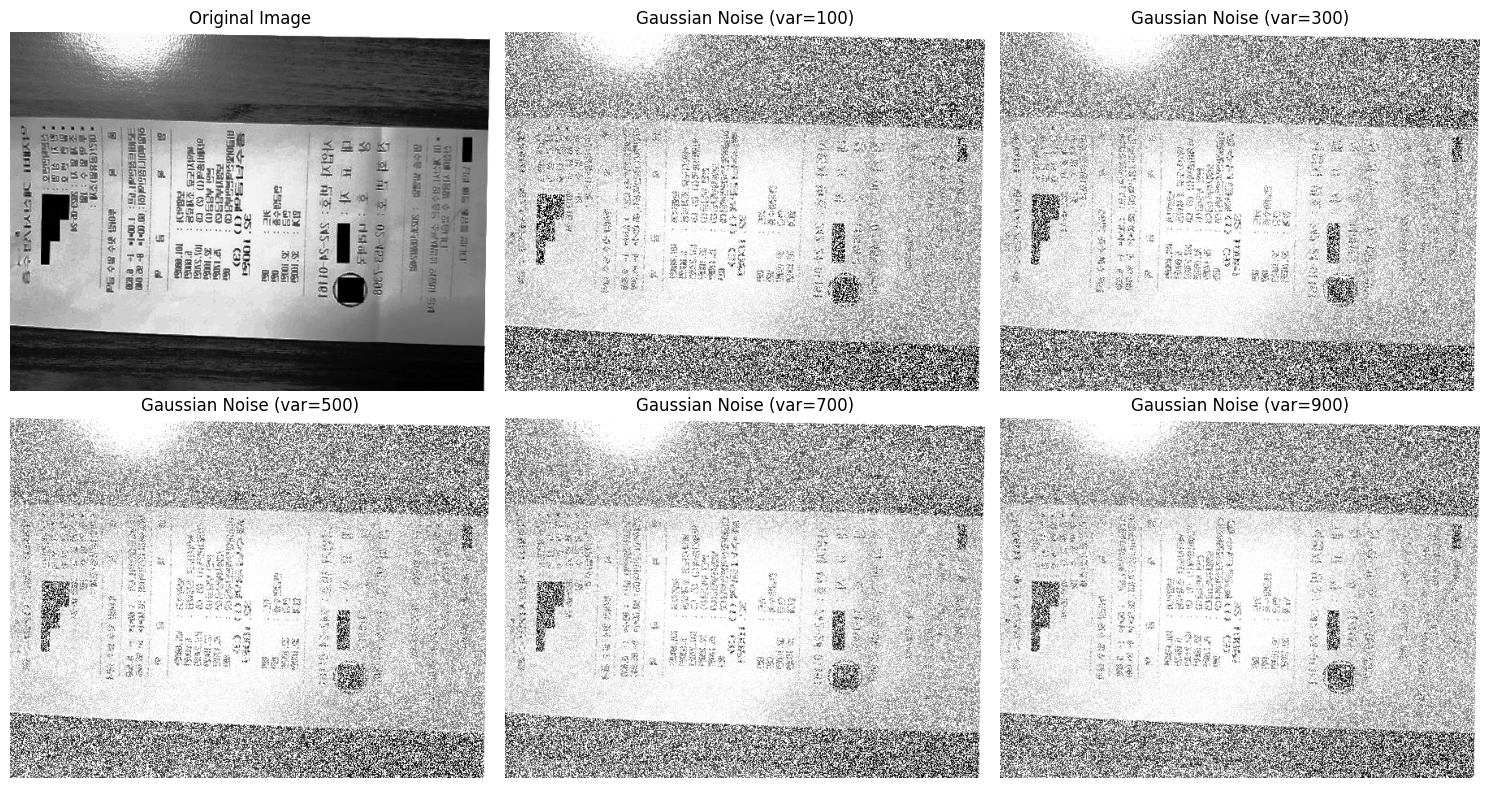

In [28]:
# 흑백 이미지 로드
image = cv2.imread("./data/test/00c0dabb63ca7a16.jpg", cv2.IMREAD_GRAYSCALE)

# 이미지 대비 향상
image_enhanced = cv2.equalizeHist(image)

# 가우시안 노이즈를 추가하는 함수
def add_gaussian_noise(image, mean=0, var=100):
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# 다양한 분산값으로 가우시안 노이즈를 추가한 이미지 생성
noise_vars = [100, 300, 500, 700, 900]
noisy_images = [add_gaussian_noise(image_enhanced, var=var) for var in noise_vars]

# 원본 이미지와 노이즈가 추가된 이미지를 시각적으로 비교
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image_enhanced, cmap='gray')
plt.axis('off')

for i, (noisy_image, var) in enumerate(zip(noisy_images, noise_vars), 2):
    plt.subplot(2, 3, i)
    plt.title(f'Gaussian Noise (var={var})')
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

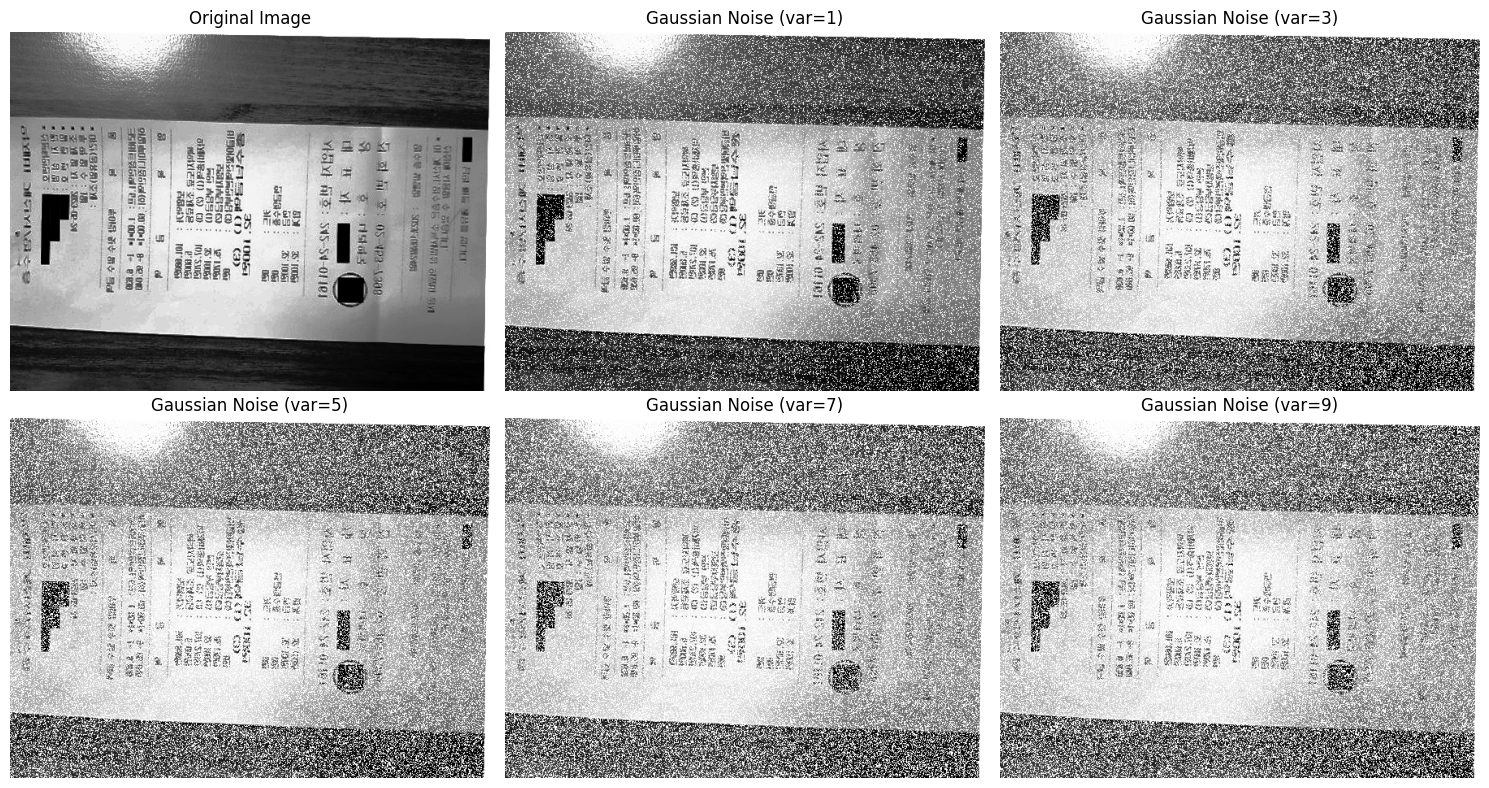

In [30]:
# 흑백 이미지 로드
image = cv2.imread("./data/test/00c0dabb63ca7a16.jpg", cv2.IMREAD_GRAYSCALE)

# 이미지 대비 향상
image_enhanced = cv2.equalizeHist(image)

# 가우시안 노이즈를 추가하는 함수
def add_gaussian_noise(image, mean=0, var=100):
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# 다양한 분산값으로 가우시안 노이즈를 추가한 이미지 생성
noise_vars = [1, 3, 5, 7, 9]
noisy_images = [add_gaussian_noise(image_enhanced, var=var) for var in noise_vars]

# 원본 이미지와 노이즈가 추가된 이미지를 시각적으로 비교
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image_enhanced, cmap='gray')
plt.axis('off')

for i, (noisy_image, var) in enumerate(zip(noisy_images, noise_vars), 2):
    plt.subplot(2, 3, i)
    plt.title(f'Gaussian Noise (var={var})')
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

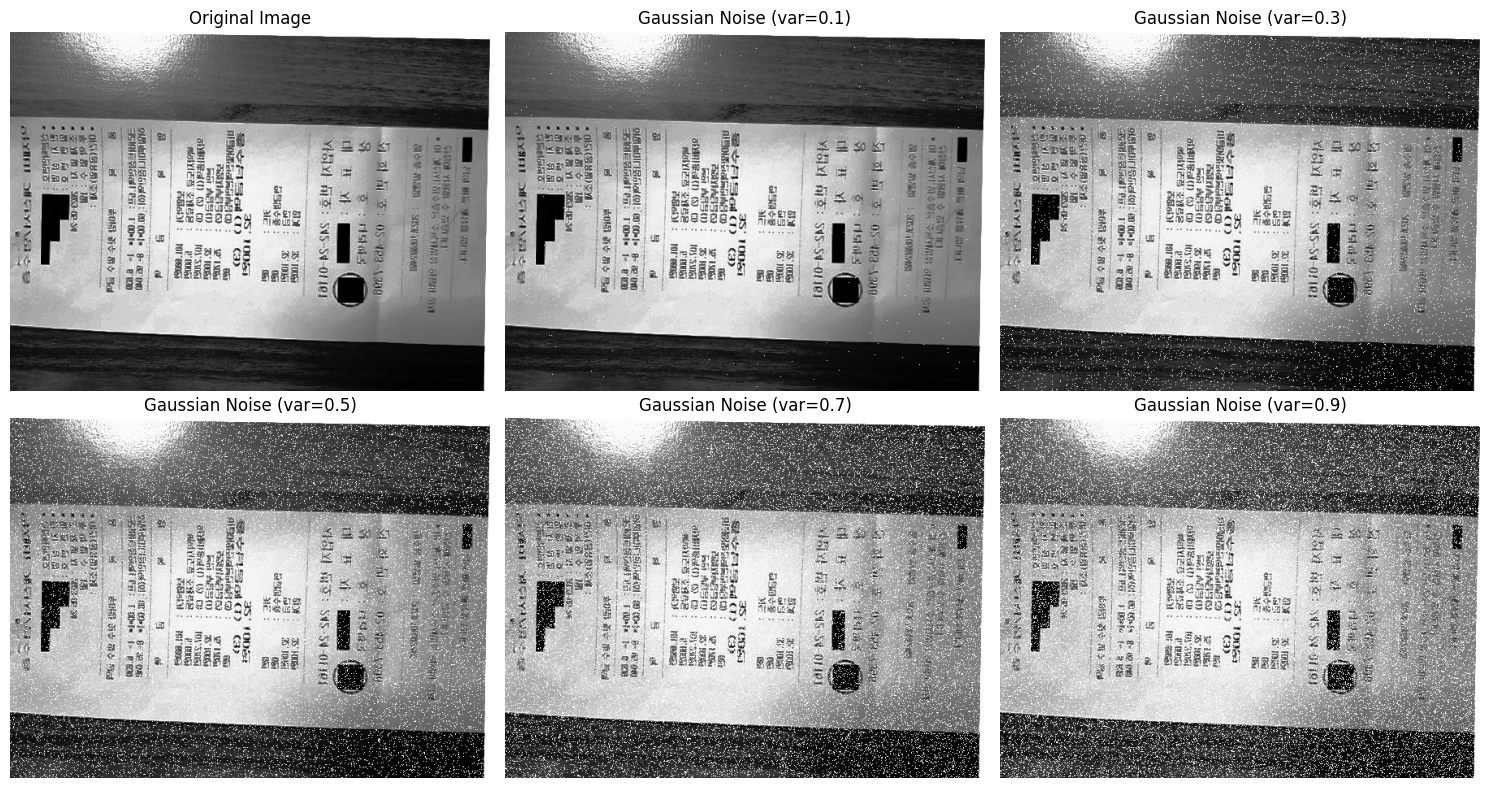

In [31]:
# 흑백 이미지 로드
image = cv2.imread("./data/test/00c0dabb63ca7a16.jpg", cv2.IMREAD_GRAYSCALE)

# 이미지 대비 향상
image_enhanced = cv2.equalizeHist(image)

# 가우시안 노이즈를 추가하는 함수
def add_gaussian_noise(image, mean=0, var=100):
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

# 다양한 분산값으로 가우시안 노이즈를 추가한 이미지 생성
noise_vars = [0.1, 0.3, 0.5, 0.7, 0.9]
noisy_images = [add_gaussian_noise(image_enhanced, var=var) for var in noise_vars]

# 원본 이미지와 노이즈가 추가된 이미지를 시각적으로 비교
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(image_enhanced, cmap='gray')
plt.axis('off')

for i, (noisy_image, var) in enumerate(zip(noisy_images, noise_vars), 2):
    plt.subplot(2, 3, i)
    plt.title(f'Gaussian Noise (var={var})')
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

- 평가 데이터에 적용된 Augmentation 파악
1. Rotation
2. Flip
3. Rotation + Flip
4. Crop
5. Adding Noise